In [37]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch
import torch.nn as nn
import math
import random

In [67]:
import random
import statistics

In [11]:
audio_data, sr = librosa.load('C:\\Downloads\\birds\\wavfiles\\97957-2.wav')


-0.009502881
(66150,)


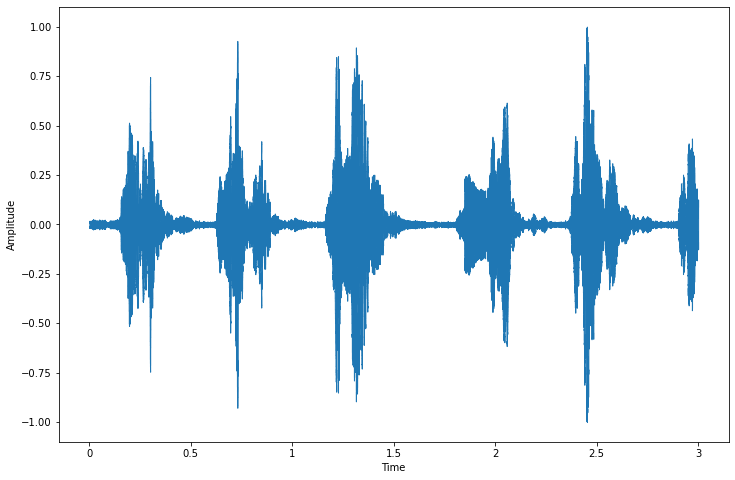

In [20]:

print(np.shape(audio_data))
plt.figure(figsize=(12, 8))
librosa.display.waveshow(audio_data, sr=sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [8]:
# Creating labels
bird_labels = pd.read_csv("C:\\Downloads\\birds\\bird_songs_metadata.csv", usecols=['species'])
bird_labels = bird_labels.values
bird_labels[bird_labels == ['bewickii']] = 0
bird_labels[bird_labels == ['polyglottos']] = 1
bird_labels[bird_labels == ['migratorius']] = 2
bird_labels[bird_labels == ['melodia']] = 3
bird_labels[bird_labels == ['cardinalis']] = 4
bird_labels = np.squeeze(bird_labels)

# Creating list of file paths
file_names = pd.read_csv("C:\\Downloads\\birds\\bird_songs_metadata.csv", usecols=['filename'])
file_names = np.squeeze(file_names.values)
bird_filepaths = np.array([])
for file in file_names:
    bird_filepaths = np.append(bird_filepaths, 'C:\\Downloads\\birds\\wavfiles\\'+file)

In [49]:
def read_file(path):
    y,_ = librosa.load(path)
    y = y.tolist()
    return y

In [50]:
l = read_file(bird_filepaths[0])
print(type(l))

<class 'numpy.ndarray'>


In [51]:
bird_filepaths
bird_labels
all_data = [read_file(file) for file in bird_filepaths] #2.5 mins

In [42]:
len(all_data[0])

66150

In [26]:
minMax = preprocessing.MinMaxScaler()
allNorm = minMax.fit_transform(all_data)

print("Example before normalization:\n",all_data[0])
print("Example after normalization:\n",allNorm[0])


Example before normalization:
 [-0.01094717 -0.03648704 -0.08890423 ... -0.18464646 -0.18991399
 -0.20194902]
Example after normalization:
 [0.49549722 0.4803521  0.45554788 ... 0.3668301  0.34124177 0.4125682 ]


In [31]:
print(len(all_data),len(bird_labels))
print(all_data[0])

5422 5422
[-0.01094717 -0.03648704 -0.08890423 ... -0.18464646 -0.18991399
 -0.20194902]


In [52]:
data_and_labels = []
for i in range(len(all_data)):
    temp = []
    temp.append(torch.FloatTensor(all_data[i]))
    temp.append(bird_labels[i])
    data_and_labels.append(temp)

In [53]:
data_and_labels[0]

[tensor([-0.0109, -0.0365, -0.0889,  ..., -0.1846, -0.1899, -0.2019]), 0]

In [62]:
#Creating our LSTM class

import torch.nn as nn

class Net(nn.Module):
    def __init__(self, numLay, numItem, inSize, hidSize, seqLen,batch_size=128):
        super(Net, self).__init__()
        self.numLay = numLay
        self.numItem =numItem
        self.inSize = inSize
        self.hidSize = hidSize
        self.seqLen = seqLen
        self.batch_size = batch_size
        
        self.lstm1 = nn.LSTMCell(input_size=inSize, hidden_size=hidSize)
        self.lstm2 = nn.LSTMCell(input_size=hidSize, hidden_size=hidSize)
        self.lstm3 = nn.LSTMCell(input_size=hidSize, hidden_size=hidSize)
        self.linear1 = nn.Linear(hidSize,numItem)
        self.out = nn.Softmax(dim=0)
        
    def forward(self, x):
        h_0 = torch.zeros(self.hidSize, dtype=torch.float32)
        c_0 = torch.zeros(self.hidSize, dtype=torch.float32)
        
        h_1 = torch.zeros(self.hidSize, dtype=torch.float32)
        c_1 = torch.zeros(self.hidSize, dtype=torch.float32)
        
        h_2 = torch.zeros(self.hidSize, dtype=torch.float32)
        c_2 = torch.zeros(self.hidSize, dtype=torch.float32)
        
        h_3 = torch.zeros(self.hidSize, dtype=torch.float32)
        c_3 = torch.zeros(self.hidSize, dtype=torch.float32)
        
        
        h_1, c_1 = self.lstm1(x, (h_0, c_0)) # 5244 x 128
        h_2, c_2 = self.lstm2(h_1, (h_1, c_1)) # 128 x 128
        h_3, c_3 = self.lstm3(h_2, (h_2, c_2))  # 128 x 128
        h_4 = self.linear1(h_3) # 128
        out = self.out(h_4) # 3
        
        return out

In [73]:
#Training and Testing Model

net = Net(5, 5, 66150, 128, 66150)
crit= torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.005)


allLoss = []
allFailed = []
allC = []
accuracy = []

for i in range(5):
    print("starting epoch",i)
    epochLoss = []
    correct = 0
    classC = [0,0,0]
    
    fedIn = data_and_labels
    random.shuffle(fedIn)
    fedIn = fedIn[:1000]
    for j in range(len(fedIn)):
        input = fedIn[j][0]
        label = [0,0,0,0,0]
        label[fedIn[j][1]] = 1
        label = torch.FloatTensor(label)
        # print(label)
        # input = fedIn[j][0].unsqueeze(0)
        
        out = net(input)
        # print(out)
        loss = crit(out, label)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epochLoss.append(loss.item())
        
        outList = out.tolist()
        outAList = label.tolist()
        
        guess = torch.topk(out, 1)
        if(guess[1] == fedIn[j][1]):
            # print("correct! guess was",guess[1],"tag was",fedIn[j][1])
            correct+=1
            # print("incorrect: guess was",guess[1],"tag was",fedIn[j][1])
    # print("corrected, incorrect:",cnt)
        if j % 10 == 0:
            print("trained datapoints:",j)
            print("total correct:",correct)
            print("amount correct: ",correct/(j+1))
    print("total correct:",correct)
    print("amount correct: ",correct/(len(fedIn)))
    accuracy.append(correct/(len(fedIn)))
    allLoss.append(statistics.mean(epochLoss))
    # print(cnt)
    # print(str(i+1) + ": " + str(allLoss[i]))

starting epoch 0
trained datapoints: 0
total correct: 0
amount correct:  0.0
trained datapoints: 10
total correct: 2
amount correct:  0.18181818181818182
trained datapoints: 20
total correct: 3
amount correct:  0.14285714285714285
trained datapoints: 30
total correct: 4
amount correct:  0.12903225806451613
trained datapoints: 40
total correct: 6
amount correct:  0.14634146341463414
trained datapoints: 50
total correct: 10
amount correct:  0.19607843137254902
trained datapoints: 60
total correct: 11
amount correct:  0.18032786885245902
trained datapoints: 70
total correct: 15
amount correct:  0.2112676056338028
trained datapoints: 80
total correct: 17
amount correct:  0.20987654320987653
trained datapoints: 90
total correct: 18
amount correct:  0.1978021978021978
trained datapoints: 100
total correct: 21
amount correct:  0.2079207920792079
trained datapoints: 110
total correct: 23
amount correct:  0.2072072072072072
trained datapoints: 120
total correct: 25
amount correct:  0.2066115702

In [74]:
accuracy

[0.222, 0.248, 0.287, 0.288, 0.304]